# Advanced Macroeconomics 1: Homework 3

## Settings

In [2]:
######################################################
# 📦 Package Imports
######################################################

# === Data Manipulation ===
import pandas as pd                # DataFrame handling
import numpy as np                # Numerical operations
import random                     # For reproducibility

# === Visualization ===
import matplotlib.pyplot as plt   # General plotting
import seaborn as sns             # Statistical visualization

# === Time Series & Statistical Models ===
import statsmodels.api as sm
from statsmodels.tsa.stattools import (
    adfuller,                     # Augmented Dickey-Fuller Test
    kpss,                         # KPSS Test
    acf, pacf                     # Autocorrelation functions
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import (
    plot_acf,                     # ACF plot
    plot_pacf                     # PACF plot
)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box test
from statsmodels.tsa.api import VAR                      # VAR model
from arch.unitroot import PhillipsPerron, ZivotAndrews   # Unit root tests

# === Machine Learning Metrics ===
from sklearn.metrics import mean_squared_error           # Model evaluation

# === Optional External Data Sources ===
import ipeadatapy as ipea                                # IPEA database (optional)

# === Utilities ===
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# === Reproducibility ===
seed = 42
np.random.seed(seed)
random.seed(seed)

# === Custom Color ===
red_color = (162 / 255, 37 / 255, 56 / 255)




In [3]:
warnings.filterwarnings("ignore")

## Questions

### Question 1

Obtain the monthly time series for the following variables: IPCA inflation, IBC-Br (series 24363 from the Brazilian Central Bank), SELIC interest rate, commodity price index (series 27574 from the Central Bank), and the exchange rate. Construct a measure of the real interest rate using the IPCA as the deflator. Use data starting from January 2000.

With these series, estimate a Vector Autoregression (VAR) model using monthly data, imposing a recursive identification scheme (Cholesky decomposition). The ordering of the variables in the VAR should be as follows: IPCA inflation, real interest rate (constructed), commodity price index, IBC-Br, and exchange rate.

#### Data

In [6]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2822,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2823,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2824,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [7]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()

# Calculate monthly inflation from IPCA index
df_ipca['monthly_inflation'] = df_ipca['IPCA'] / df_ipca['IPCA'].shift(1) - 1

df_ipca['monthly_inflation'] = df_ipca['monthly_inflation'].round(5)
df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

# Preview
df_ipca.head()


,IPCA,monthly_inflation
date,,
1979-12-01,0.0,NaN
1980-01-01,0.0,0.06616
1980-02-01,0.0,0.04617
1980-03-01,0.0,0.06038
1980-04-01,0.0,0.05286


In [8]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation
df_ibcbr['delta_IBCBR'] = df_ibcbr['IBC-Br'] / df_ibcbr['IBC-Br'].shift(1) - 1

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)
df_ibcbr['delta_IBCBR'] = df_ibcbr['delta_IBCBR'].round(5)

# Preview
df_ibcbr.head()

,IBC-Br,delta_IBCBR
date,,
2003-01-01,67.44572,NaN
2003-02-01,69.20861,0.02614
2003-03-01,72.53661,0.04809
2003-04-01,71.67673,-0.01185
2003-05-01,70.35122,-0.01849


In [9]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

# Preview
df_selic.head()


,SELIC,selic_dec
date,,
1974-01-01,1.46,0.0146
1974-02-01,1.15,0.0115
1974-03-01,1.16,0.0116
1974-04-01,1.21,0.0121
1974-05-01,1.24,0.0124


In [10]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()


# Calculate monthly inflation from IPCA index
df_commodity['monthly_Commodity_inflation'] = df_commodity['Commodity_Price_Index'] / df_commodity['Commodity_Price_Index'].shift(1) - 1

df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)
df_commodity['monthly_Commodity_inflation'] = df_commodity['monthly_Commodity_inflation'].round(5)

# Preview
df_commodity.head()


,Commodity_Price_Index,monthly_Commodity_inflation
date,,
2000-01-01,51.41,NaN
2000-02-01,50.22,-0.02315
2000-03-01,49.51,-0.01414
2000-04-01,50.31,0.01616
2000-05-01,53.18,0.05705


In [11]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate',  # Corrigido! Estava escrito 'SELIC' por engano
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()

# Calculate monthly inflation from IPCA index
df_fx['delta_FX_Rate'] = df_fx['FX_Rate'] / df_fx['FX_Rate'].shift(1) - 1

df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)
df_fx['delta_FX_Rate']  = df_fx['delta_FX_Rate'] .round(5)


# Preview
df_fx.head()

,FX_Rate,delta_FX_Rate
date,,
1930-01-01,0.0,NaN
1930-02-01,0.0,0.00000
1930-03-01,0.0,-0.03333
1930-04-01,0.0,-0.02299
1930-05-01,0.0,0.00000


In [12]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

In [13]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['monthly_inflation']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)

In [14]:
# Select the variables of interest for the VAR
vars_var = df[['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

monthly_inflation        0
real_interest_rate       0
Commodity_Price_Index    0
IBC-Br                   0
FX_Rate                  0
dtype: int64


#### Plot series

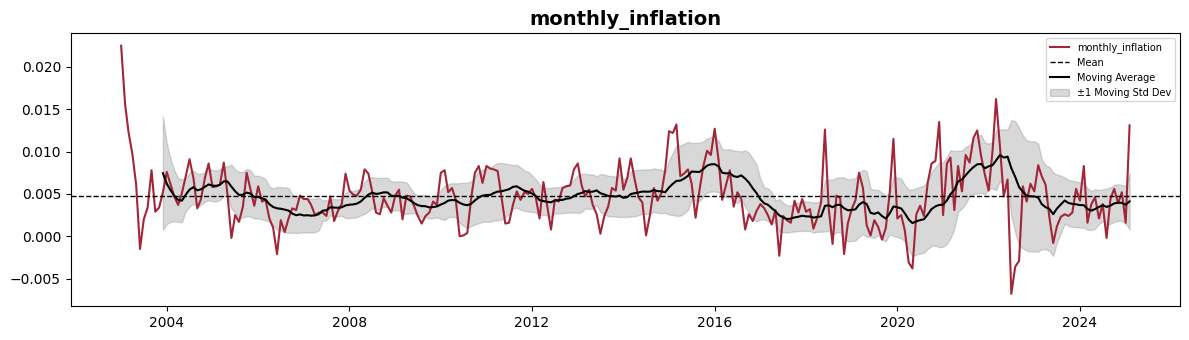

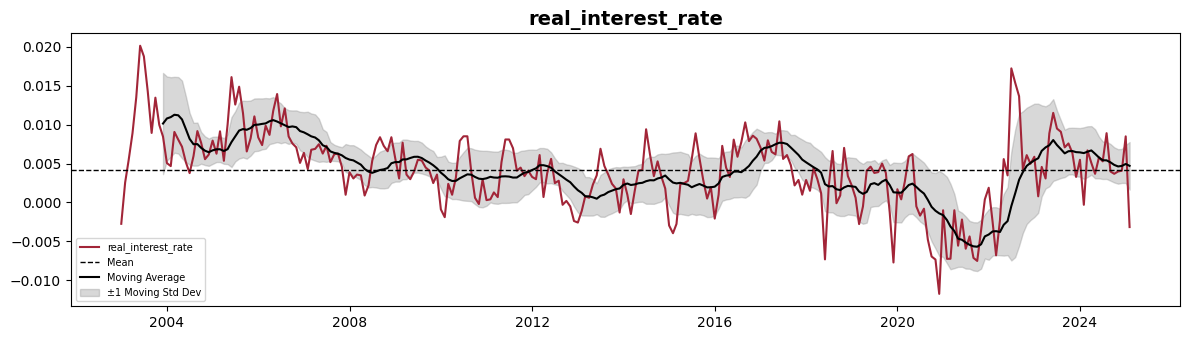

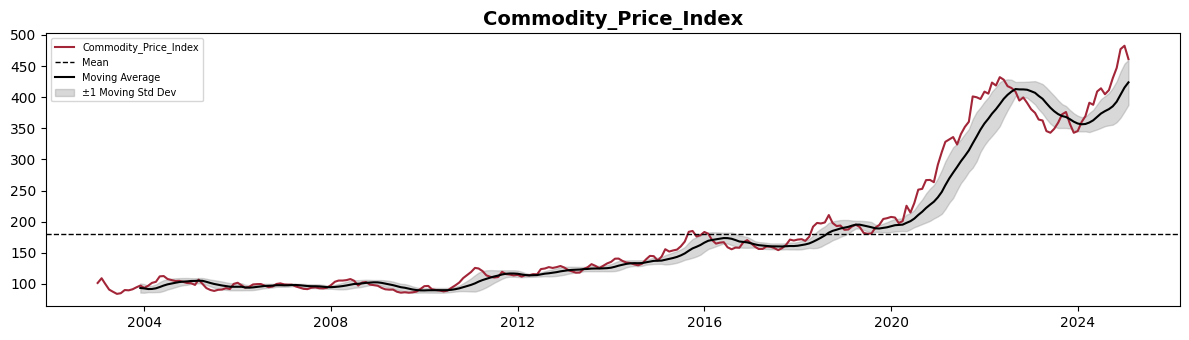

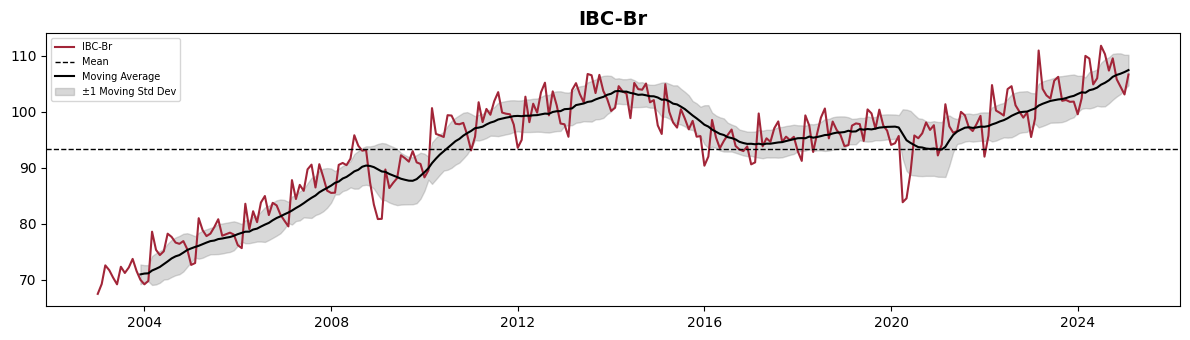

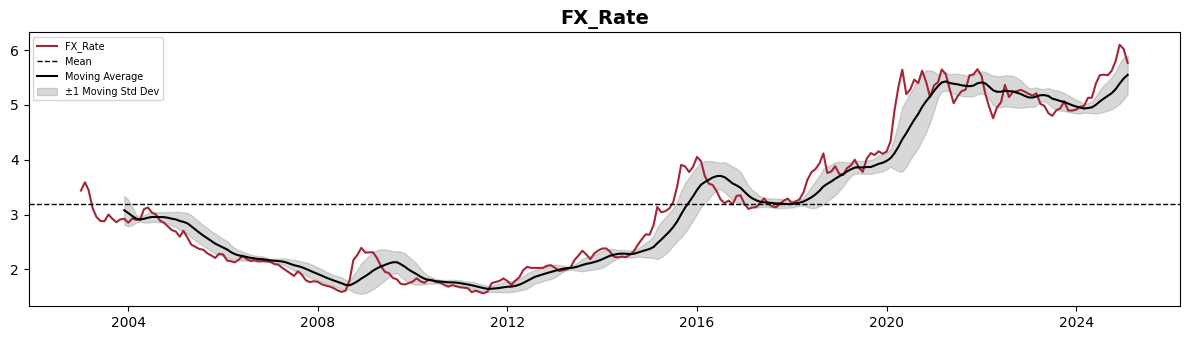

In [15]:
# Graph
window_size = 12

# Loop through each variable in the VAR dataset
for column in vars_var.columns:
    
    # Calculate moving average and moving standard deviation
    moving_mean = vars_var[column].rolling(window=window_size).mean()
    moving_std = vars_var[column].rolling(window=window_size).std()
    
    # Calculate the overall mean and standard deviation of the series
    mean_value = vars_var[column].mean()
    std_dev = vars_var[column].std()
    
    # Create the plot
    plt.figure(figsize=(12, 3.5))
    
    # Plot the original series
    plt.plot(vars_var.index, vars_var[column], color=red_color, linewidth=1.5, label=f"{column}")
    
    # Plot the overall mean line
    plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')
    
    # Plot the moving average
    plt.plot(vars_var.index, moving_mean, color='black', linestyle='-', linewidth=1.5, label="Moving Average")
    
    # Plot the ±1 moving standard deviation bands
    plt.fill_between(vars_var.index, 
                     moving_mean - moving_std, 
                     moving_mean + moving_std, 
                     color='grey', alpha=0.3, label='±1 Moving Std Dev')

    # Add title and customize plot
    plt.title(f"{column}", fontsize=14, fontweight='bold')
    plt.legend(fontsize=7, loc='best')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

#### Choose lags for VAR model based on AIC, SBC, and HQ criteria

In [16]:
# Fit VAR model
model = VAR(vars_var)

# Initialize dictionaries to store info criteria for each lag
aic_dict = {}
bic_dict = {}
hqic_dict = {}

# Test lags from 1 to 12
for lag in range(1, 13):
    result = model.fit(lag)
    aic_dict[lag] = result.aic
    bic_dict[lag] = result.bic
    hqic_dict[lag] = result.hqic

# Create DataFrame with all criteria
criteria_table = pd.DataFrame({
    'AIC': pd.Series(aic_dict),
    'BIC': pd.Series(bic_dict),
    'HQIC': pd.Series(hqic_dict)
})

print("Information Criteria by Lag:")
print(criteria_table)

# Find which lag each criterion selected
selected_orders = {
    'aic': criteria_table['AIC'].idxmin(),
    'bic': criteria_table['BIC'].idxmin(),
    'hqic': criteria_table['HQIC'].idxmin()
}

print("\nLag selected by each criterion:")
print(selected_orders)

# Count how many times each lag was selected
criteria_counts = Counter(selected_orders.values())
print("\nLag chosen by multiple criteria:")
print(criteria_counts)

# Choose the most common lag
most_common_lag = criteria_counts.most_common(1)[0][0]
print(f"\nFinal selected lag: {most_common_lag}")

# Fit final VAR model
results = model.fit(most_common_lag)


Information Criteria by Lag:
          AIC        BIC       HQIC
1  -24.112015 -23.706763 -23.949191
2  -24.576347 -23.831357 -24.276987
3  -24.827729 -23.741142 -24.391055
4  -24.943817 -23.513755 -24.369044
5  -24.985244 -23.209812 -24.271578
6  -25.117341 -22.994627 -24.263982
7  -25.377620 -22.905693 -24.383760
8  -25.427011 -22.603923 -24.291834
9  -25.471057 -22.294841 -24.193740
10 -25.544863 -22.013534 -24.124576
11 -25.801713 -21.913267 -24.237617
12 -25.993326 -21.745739 -24.284574

Lag selected by each criterion:
{'aic': np.int64(12), 'bic': np.int64(2), 'hqic': np.int64(3)}

Lag chosen by multiple criteria:
Counter({np.int64(12): 1, np.int64(2): 1, np.int64(3): 1})

Final selected lag: 12


#### Estimate the VAR model and perform the diagnostic/specification tests as discussed in class.

In [17]:
# Subset das variáveis escolhidas
cols = ['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
df_var = df[cols].dropna()

# Estimar o modelo VAR com 12 lags por MLE
model = VAR(df_var)
model_mle = model.fit(12, method='mle')

# Sumário dos resultados
print(model_mle.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     00:09:37
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -21.7457
Nobs:                     254.000    HQIC:                  -24.2846
Log likelihood:           1804.10    FPE:                5.39532e-12
AIC:                     -25.9933    Det(Omega_mle):     1.83922e-12
--------------------------------------------------------------------
Results for equation monthly_inflation
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.003014         0.004356            0.692           0.489
L1.monthly_inflation              0.673859         0.314849            2.140           0.032


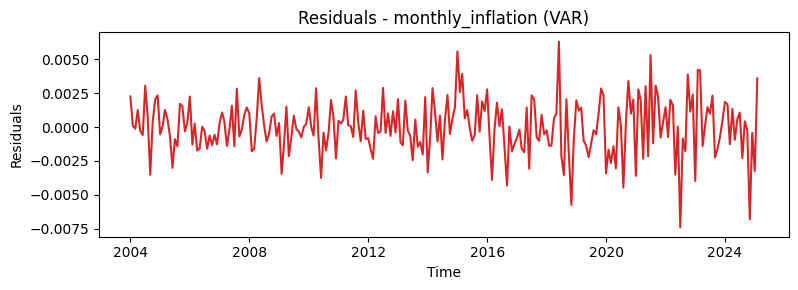

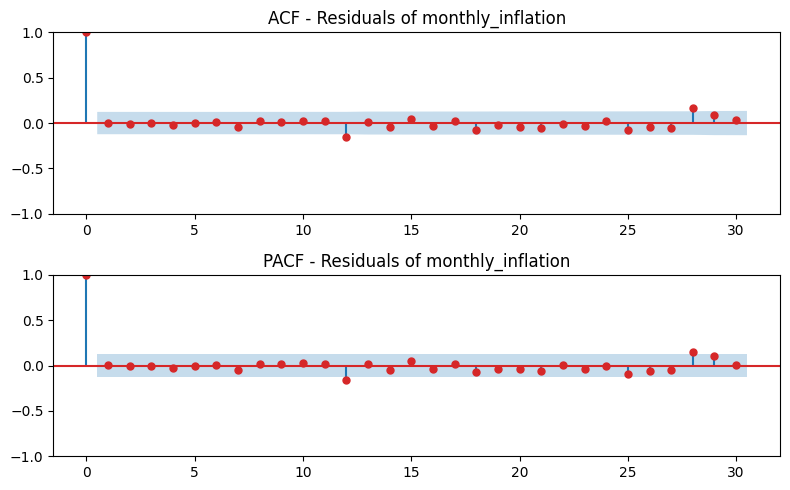

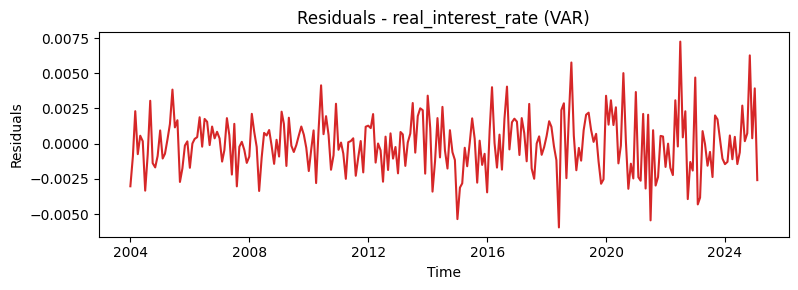

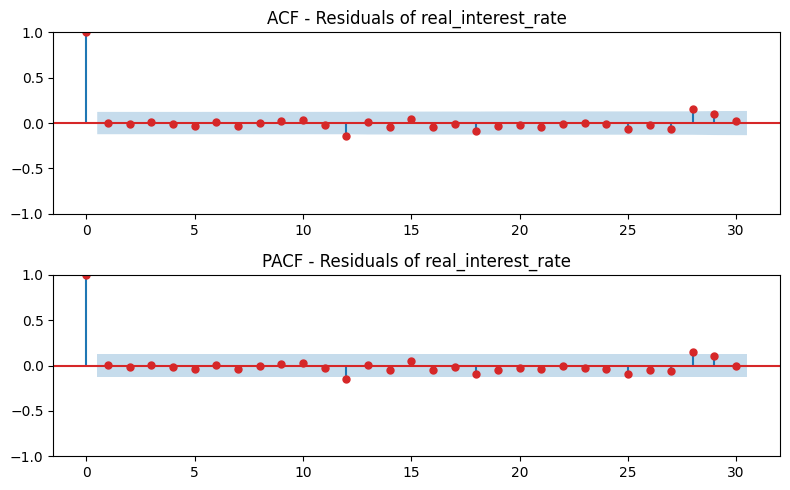

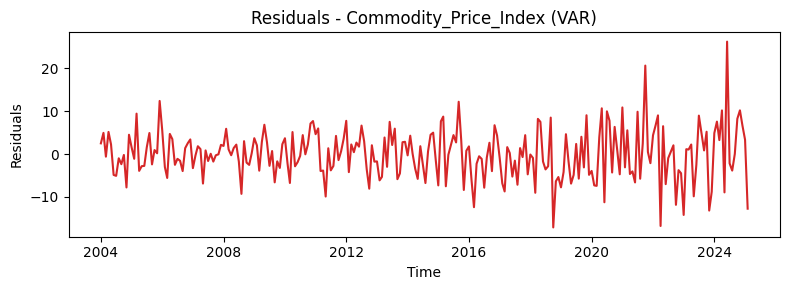

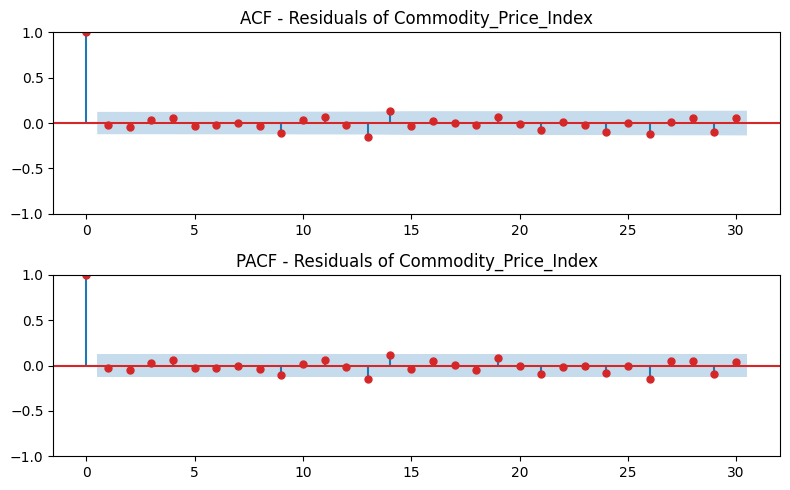

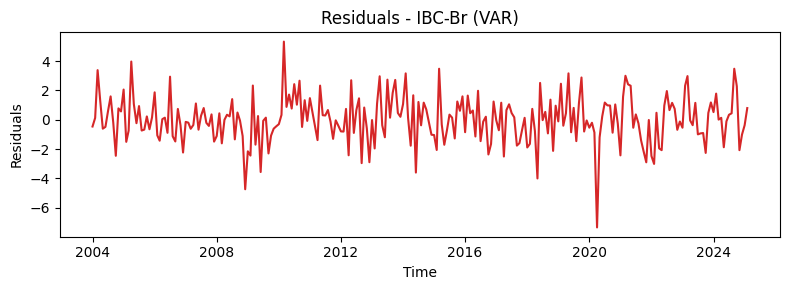

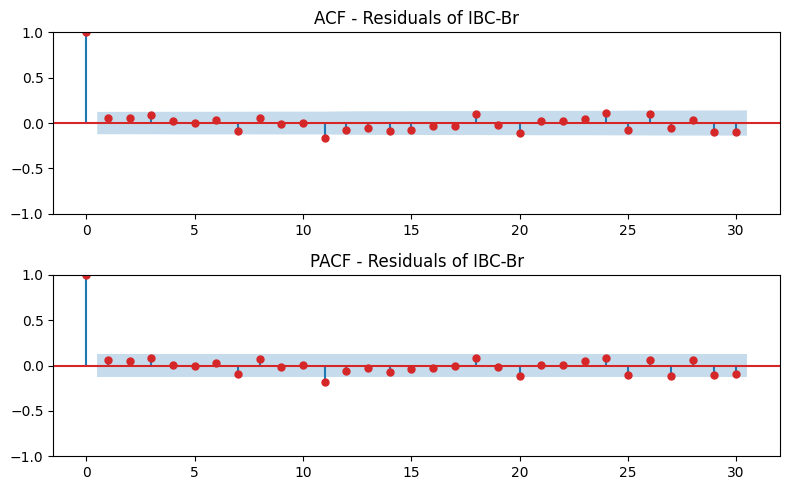

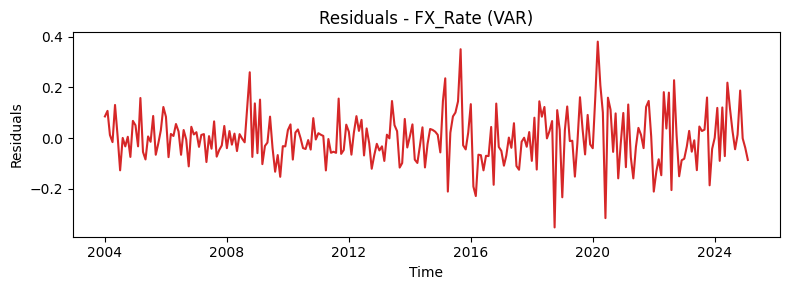

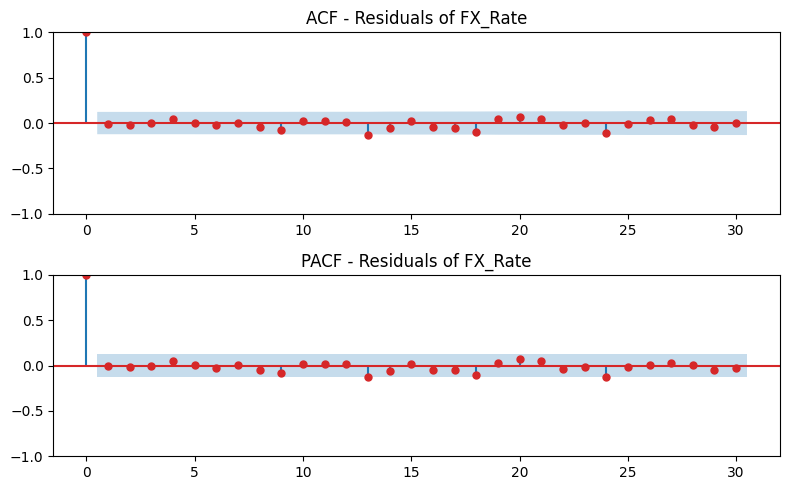

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_var_diagnostics(model, variables, lags=30, color="#d62728"):
    """
    Plot residuals, ACF, and PACF for each endogenous variable in a VAR model.

    Parameters:
    - model: fitted VAR model
    - variables: list of variable names
    - lags: number of lags for ACF/PACF plots
    - color: color for plots (default is red)
    """
    for var in variables:
        residuals = model.resid[var].dropna()

        # Residual plot
        plt.figure(figsize=(8, 3))
        plt.plot(residuals, color=color)
        plt.title(f"Residuals - {var} (VAR)")
        plt.xlabel("Time")
        plt.ylabel("Residuals")
        plt.tight_layout()
        plt.show()

        # ACF and PACF plots
        fig, axs = plt.subplots(2, 1, figsize=(8, 5))
        plot_acf(residuals, lags=lags, ax=axs[0], color=color)
        axs[0].set_title(f"ACF - Residuals of {var}")
        plot_pacf(residuals, lags=lags, ax=axs[1], color=color)
        axs[1].set_title(f"PACF - Residuals of {var}")
        plt.tight_layout()
        plt.show()

# Example usage:
variables = ['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
plot_var_diagnostics(model_mle, variables)


In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def run_ljung_box_test(model, variables, lags=10, alpha=0.05):
    """
    Runs Ljung-Box test and prints interpretation for each variable.

    Parameters:
    - model: fitted VAR model
    - variables: list of variable names
    - lags: lag used in the test
    - alpha: significance level (default = 0.05)
    """
    for var in variables:
        residuals = model.resid[var].dropna()
        test_result = acorr_ljungbox(residuals, lags=[lags], return_df=True)
        p_value = test_result["lb_pvalue"].values[0]

        print(f"\nLjung-Box test for residuals of '{var}' (lag={lags}):")
        print(f"Test statistic: {test_result['lb_stat'].values[0]:.4f}")
        print(f"p-value: {p_value:.4f}")

        if p_value < alpha:
            print("❌ Autocorrelation detected: the residuals are NOT white noise.")
        else:
            print("✅ No autocorrelation: the residuals appear to be white noise.")

# Example usage:
variables = ['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
run_ljung_box_test(model_mle, variables)



Ljung-Box test for residuals of 'monthly_inflation' (lag=10):
Test statistic: 1.1631
p-value: 0.9997
✅ No autocorrelation: the residuals appear to be white noise.

Ljung-Box test for residuals of 'real_interest_rate' (lag=10):
Test statistic: 1.1559
p-value: 0.9997
✅ No autocorrelation: the residuals appear to be white noise.

Ljung-Box test for residuals of 'Commodity_Price_Index' (lag=10):
Test statistic: 5.7636
p-value: 0.8347
✅ No autocorrelation: the residuals appear to be white noise.

Ljung-Box test for residuals of 'IBC-Br' (lag=10):
Test statistic: 6.7060
p-value: 0.7529
✅ No autocorrelation: the residuals appear to be white noise.

Ljung-Box test for residuals of 'FX_Rate' (lag=10):
Test statistic: 2.9174
p-value: 0.9833
✅ No autocorrelation: the residuals appear to be white noise.


#### Impose a recursive identification. If you have doubts about the ordering, consult Christiano, Eichenbaum, and Evans (1999) or CEE (2005). Justify the ordering.

Recursive Identification Ordering Justification (Cholesky Decomposition)

We use a recursive (Cholesky) identification scheme to orthogonalize the structural shocks in the VAR. The ordering of variables reflects economic reasoning regarding their contemporaneous interactions:

IBC-Br (economic activity) is placed first, assuming that real output does not respond contemporaneously to other shocks within the same month due to inertia in production and investment decisions.

Commodity Price Index is ordered second, as global commodity prices can be influenced by real activity but are largely determined in international markets and are unlikely to respond immediately to domestic monetary shocks.

FX Rate comes third, as exchange rates may respond quickly to changes in economic activity or commodity prices, but not necessarily to domestic monetary policy within the same month.

Monthly Inflation is ordered fourth, acknowledging that prices are sticky and typically adjust with a lag; therefore, inflation does not react contemporaneously to shocks in interest rates.

Real Interest Rate is ordered last, under the assumption that monetary policy responds contemporaneously to all other variables, reflecting a central bank that monitors the state of the economy and adjusts rates accordingly.

This ordering is consistent with standard practice in monetary VAR literature and allows us to interpret the last shock as a monetary policy innovation.

#### Obtain the IRFs for a 36-month horizon with a confidence interval of 68% or 90%. Choose the method to obtain the CI for the IRF. Explain your results. In particular, what are the effects of a monetary policy shock on the economy? Any strange results?

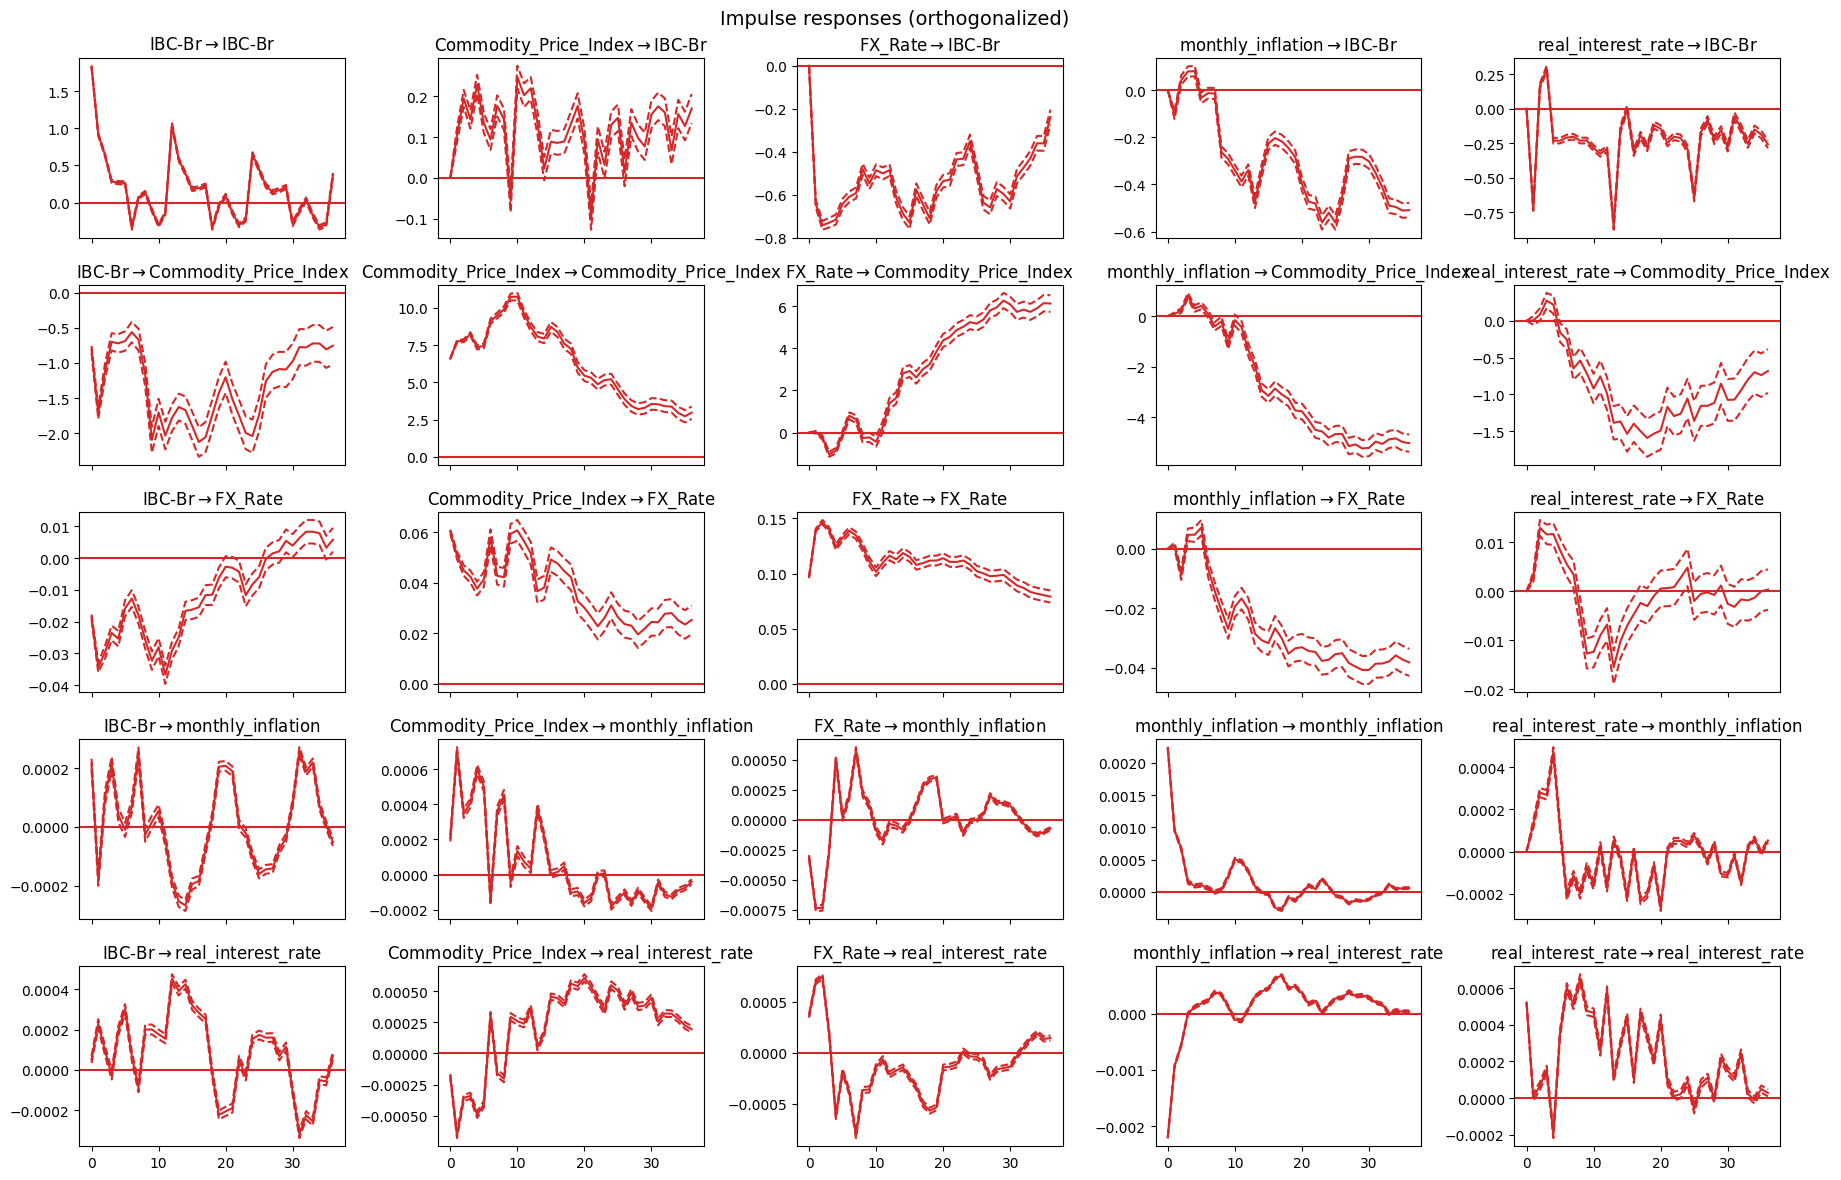

In [20]:
# Variable ordering for Cholesky identification
ordering = ['IBC-Br', 'Commodity_Price_Index', 'FX_Rate', 'monthly_inflation', 'real_interest_rate']

# Reorder the model based on Cholesky decomposition
model_ordered = model_mle.reorder(ordering)

# Generate IRFs for a 36-month horizon with 90% confidence intervals
irf = model_ordered.irf(36)

# Plot with red color and larger figure size
fig = irf.plot(orth=True, signif=0.90)
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("#d62728")  # red color

fig.set_size_inches(18, 12)  # increase figure size for clarity
plt.tight_layout()
plt.show()

#### Obtain the FEVD for 2, 6, 12, 18, 24, 36 months. What is the importance of monetary policy?

In [21]:
# Define the horizons and target variable
horizons = [2, 6, 12, 18, 24, 36]
target_var = 'monthly_inflation'
var_index = model_ordered.names.index(target_var)

# Loop through each horizon and print the FEVD results
print(f"FEVD: Variance in '{target_var}' explained by each structural shock:")

for h in horizons:
    fevd_h = model_ordered.fevd(h)
    contribs = fevd_h.decomp[var_index, :, -1]  # take the last horizon (h months)
    print(f"\nHorizon: {h} months")
    for shock, value in zip(model_ordered.names, contribs):
        print(f"{shock:25s}: {value:.4f}")


FEVD: Variance in 'monthly_inflation' explained by each structural shock:

Horizon: 2 months
IBC-Br                   : 0.0000
Commodity_Price_Index    : 0.0023

Horizon: 6 months
IBC-Br                   : 0.0000
Commodity_Price_Index    : 0.0023
FX_Rate                  : 0.0114
monthly_inflation        : 0.0192
real_interest_rate       : 0.0410

Horizon: 12 months
IBC-Br                   : 0.0000
Commodity_Price_Index    : 0.0023
FX_Rate                  : 0.0114
monthly_inflation        : 0.0192
real_interest_rate       : 0.0410

Horizon: 18 months
IBC-Br                   : 0.0000
Commodity_Price_Index    : 0.0023
FX_Rate                  : 0.0114
monthly_inflation        : 0.0192
real_interest_rate       : 0.0410

Horizon: 24 months
IBC-Br                   : 0.0000
Commodity_Price_Index    : 0.0023
FX_Rate                  : 0.0114
monthly_inflation        : 0.0192
real_interest_rate       : 0.0410

Horizon: 36 months
IBC-Br                   : 0.0000
Commodity_Price_Index    :

The variance decomposition shows that monetary policy shocks (real interest rate) explain only a small share of inflation dynamics. Even after 36 months, less than 5% of the forecast error variance of inflation is attributed to interest rate shocks. This suggests that monetary policy plays a limited role in driving short- and medium-term inflation in this model, possibly due to price stickiness, delayed transmission, or omitted variables.

### Question 2

Reestimate the VAR imposing sign restrictions. You must use Inflation (IPCA), real interest rate (the one you constructed), commodity price index, IBC-Br, and exchange rate. You may use either Uhlig (2005), Mountford and Uhlig (2009), or Arias et al. (2018) as a reference. Just choose one method and no need to explain it.

#### Data

In [5]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2822,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2823,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2824,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [6]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()

# Calculate monthly inflation from IPCA index
df_ipca['monthly_inflation'] = df_ipca['IPCA'] / df_ipca['IPCA'].shift(1) - 1

df_ipca['monthly_inflation'] = df_ipca['monthly_inflation'].round(5)
df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

# Preview
df_ipca.head()


,IPCA,monthly_inflation
date,,
1979-12-01,0.0,NaN
1980-01-01,0.0,0.06616
1980-02-01,0.0,0.04617
1980-03-01,0.0,0.06038
1980-04-01,0.0,0.05286


In [7]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation
df_ibcbr['delta_IBCBR'] = df_ibcbr['IBC-Br'] / df_ibcbr['IBC-Br'].shift(1) - 1

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)
df_ibcbr['delta_IBCBR'] = df_ibcbr['delta_IBCBR'].round(5)

# Preview
df_ibcbr.head()

,IBC-Br,delta_IBCBR
date,,
2003-01-01,67.44572,NaN
2003-02-01,69.20861,0.02614
2003-03-01,72.53661,0.04809
2003-04-01,71.67673,-0.01185
2003-05-01,70.35122,-0.01849


In [8]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

# Preview
df_selic.head()


,SELIC,selic_dec
date,,
1974-01-01,1.46,0.0146
1974-02-01,1.15,0.0115
1974-03-01,1.16,0.0116
1974-04-01,1.21,0.0121
1974-05-01,1.24,0.0124


In [9]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()


# Calculate monthly inflation from IPCA index
df_commodity['monthly_Commodity_inflation'] = df_commodity['Commodity_Price_Index'] / df_commodity['Commodity_Price_Index'].shift(1) - 1

df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)
df_commodity['monthly_Commodity_inflation'] = df_commodity['monthly_Commodity_inflation'].round(5)

# Preview
df_commodity.head()


,Commodity_Price_Index,monthly_Commodity_inflation
date,,
2000-01-01,51.41,NaN
2000-02-01,50.22,-0.02315
2000-03-01,49.51,-0.01414
2000-04-01,50.31,0.01616
2000-05-01,53.18,0.05705


In [10]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate',  # Corrigido! Estava escrito 'SELIC' por engano
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()

# Calculate monthly inflation from IPCA index
df_fx['delta_FX_Rate'] = df_fx['FX_Rate'] / df_fx['FX_Rate'].shift(1) - 1

df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)
df_fx['delta_FX_Rate']  = df_fx['delta_FX_Rate'] .round(5)


# Preview
df_fx.head()

,FX_Rate,delta_FX_Rate
date,,
1930-01-01,0.0,NaN
1930-02-01,0.0,0.00000
1930-03-01,0.0,-0.03333
1930-04-01,0.0,-0.02299
1930-05-01,0.0,0.00000


In [11]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

In [12]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['monthly_inflation']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)

In [13]:
# Select the variables of interest for the VAR
vars_var = df[['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

monthly_inflation        0
real_interest_rate       0
Commodity_Price_Index    0
IBC-Br                   0
FX_Rate                  0
dtype: int64


#### Present in a table the imposed restrictions and indicate the time period you used to impose the restrictions.

Sign Restrictions for Monetary Policy Shock (Uhlig, 2005)

| Variable               | Expected Sign | Horizon (months) |
|------------------------|----------------|------------------|
| `real_interest_rate`   | **Positive**   | 0 to 4           |
| `IBC-Br`               | **Negative**   | 0 to 4           |
| `FX_Rate`              | **Negative**   | 0 to 4           |
| `Commodity_Price_Index`| **Negative**   | 0 to 4           |
| `monthly_inflation`    | **Negative**   | 0 to 4           |

In [16]:
from numpy.linalg import cholesky, qr
from statsmodels.tsa.api import VAR

In [17]:
# Step 0: Data already prepared in df, with columns ordered like this:
variables = ['IBC-Br', 'Commodity_Price_Index', 'FX_Rate', 'monthly_inflation', 'real_interest_rate']
df_var = df[variables].dropna()

# Estimate the VAR
model = VAR(df_var)
model_fitted = model.fit(12)

# Get parameters
A0 = model_fitted.sigma_u  # residual covariance matrix
chol = cholesky(A0)
irf_base = model_fitted.irf(36)  # to reuse for IRF calculations

In [ ]:
# Define sign restrictions for monetary policy shock (real_interest_rate shock)
# simhese signs over horizons 0 to 4
sign_restrictions = {
    'real_interest_rate': +1,
    'IBC-Br': -1,
    'FX_Rate': -1,
    'Commodity_Price_Index': -1,
    'monthly_inflation': -1
}
horizons = range(0, 5)  # months 0 to 4

def satisfies_sign_restrictions(irfs, shock_index):
    for var_idx, var in enumerate(variables):
        expected_sign = sign_restrictions[var]
        for h in horizons:
            impulse = irfs[h, var_idx, shock_index]
            if expected_sign * impulse < 0:
                return False
    return True

In [19]:
n_draws = 1000
accepted_irfs = []

for i in range(n_draws):
    Q, _ = qr(np.random.normal(size=(len(variables), len(variables))))
    B = chol @ Q
    irfs = irf_base.orth_irfs @ Q  # shape: [horizon, variable, shock]
    
    # Shock is last variable (real_interest_rate)
    if satisfies_sign_restrictions(irfs, shock_index=variables.index('real_interest_rate')):
        accepted_irfs.append(irfs)

print(f"{len(accepted_irfs)} draws accepted out of {n_draws}")


13 draws accepted out of 1000


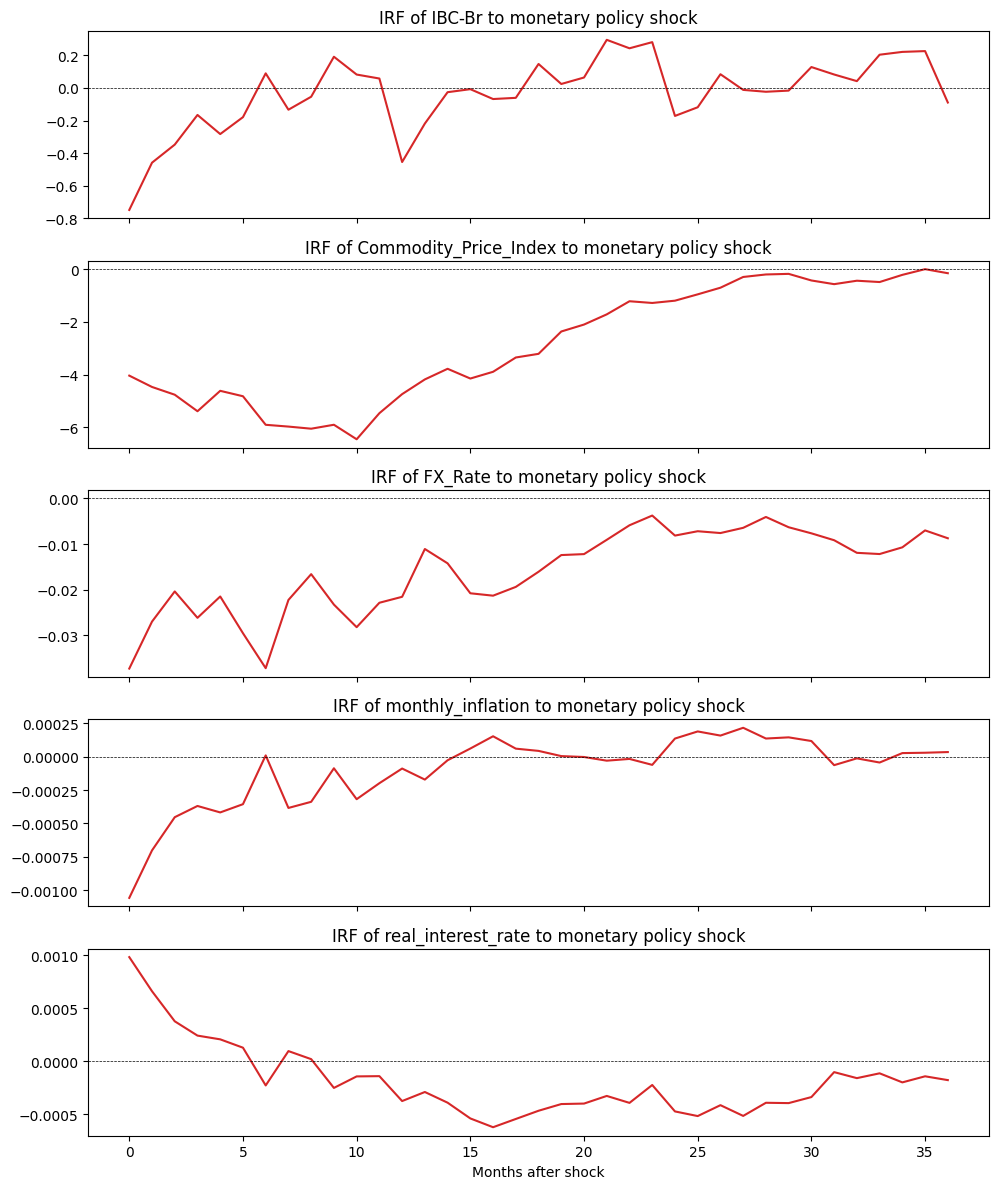

In [24]:

accepted_irfs = np.array(accepted_irfs)  # shape: [n_accepts, horizon, variable, shock]

# Average across accepted draws
mean_irfs = accepted_irfs.mean(axis=0)

# Plot
horizon_range = np.arange(mean_irfs.shape[0])
shock_index = variables.index('real_interest_rate')

fig, axs = plt.subplots(len(variables), 1, figsize=(10, 12), sharex=True)

for i, var in enumerate(variables):
    axs[i].plot(horizon_range, mean_irfs[:, i, shock_index], color="#d62728")
    axs[i].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axs[i].set_title(f"IRF of {var} to monetary policy shock")
    # axs[i].grid(True)  # grid removed

plt.xlabel("Months after shock")
plt.tight_layout()
plt.show()


In [21]:
def compute_fevd(irfs, horizon):
    """
    Compute FEVD for a given set of IRFs and a specified horizon.
    irfs: shape (H, n_vars, n_shocks)
    """
    n_vars = irfs.shape[1]
    fevd_matrix = np.zeros((n_vars, n_vars))  # rows: variable, cols: shock

    for i in range(n_vars):  # for each variable
        for j in range(n_vars):  # for each shock
            num = np.sum(irfs[:horizon, i, j]**2)
            denom = np.sum([np.sum(irfs[:horizon, i, k]**2) for k in range(n_vars)])
            fevd_matrix[i, j] = num / denom if denom != 0 else 0.0

    return fevd_matrix


In [22]:
horizon = 36  # you can also try 12 or 24
fevd_list = []

for irfs in accepted_irfs:
    fevd_list.append(compute_fevd(irfs, horizon=horizon))

# Média das FEVDs entre os draws aceitos
fevd_array = np.mean(fevd_list, axis=0)


In [23]:
print("FEVD for 'monthly_inflation' after", horizon, "months:")

inflation_index = variables.index("monthly_inflation")
for shock_index, shock in enumerate(variables):
    contribution = fevd_array[inflation_index, shock_index]
    print(f"{shock:25s}: {contribution:.4f}")


FEVD for 'monthly_inflation' after 36 months:
IBC-Br                   : 0.1368
Commodity_Price_Index    : 0.1882
FX_Rate                  : 0.2649
monthly_inflation        : 0.1548
real_interest_rate       : 0.2554


The forecast error variance decomposition reveals that monetary policy plays a significant role in explaining inflation dynamics under sign restrictions.
After 36 months, approximately 25.5% of the variance in monthly inflation is attributed to shocks in the real interest rate. This is a considerably stronger result compared to the recursive identification, where the monetary policy channel explained less than 5%.

Moreover, the exchange rate (FX_Rate) and commodity prices also account for sizable shares of inflation variance (26.5% and 18.8%, respectively), suggesting that external and pass-through effects are relevant channels. The contribution of inflation's own shocks and output (IBC-Br) is more modest.